# Monte Carlo - Forecasting Stock Prices

In [1]:
# Importing libraries
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

In [2]:
def generate_forecasts(ticker='^GSPC', t_intervals=50, iterations=1000, start='2000-1-1', end=None):
    """
    This function generates forecasts of the closing price of a stock, 
    using data from that ticker using yahoo finance
    
    Param: t_intervals - the number of time intervals in the forecast
    Param: iterations - the number of forecasts
    Param: start - start date to retrieve data from
    Param: end - end date to retrieve data from
    """
    
    # Getting data
    data = wb.DataReader(ticker, data_source='yahoo', start=start, end=end)['Adj Close']
    
    # Calculating information about the returns
    log_returns = np.log(1 + data.pct_change())
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()
    
    # Generating daily returns using this information
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
    
    # Last closing price from the data
    S0 = data.iloc[-1]
    
    # Create a variable price_list with the same dimension as the daily_returns matrix. 
    price_list = np.zeros_like(daily_returns)
    
    # Set the values on the first row of the price_list array equal to S0.
    price_list[0] = S0
    
    # Create a loop in the range (1, t_intervals) that reassigns to the price in time t 
    # the product of the price in day (t-1) with the value of the daily returns in t.
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    
    # Plot the forecasts
    plt.figure(figsize=(15,8))
    plt.plot(price_list)

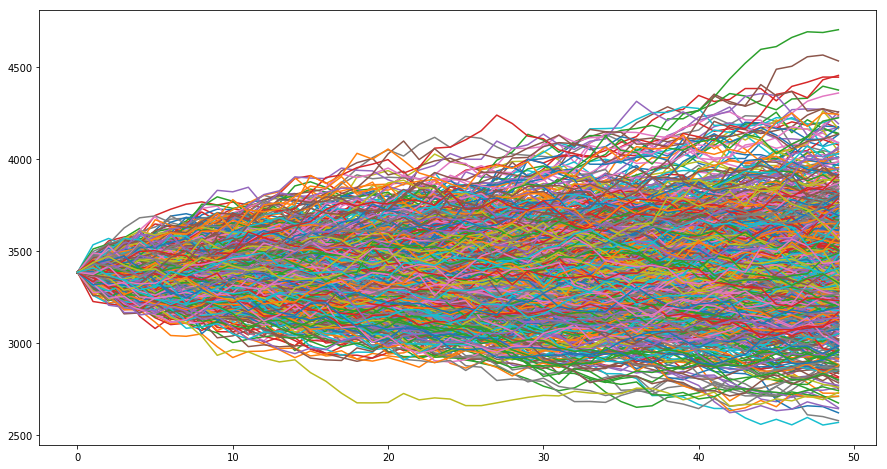

In [3]:
generate_forecasts()

Pricing a call option using this, using the formula:

$$
C = \frac{exp(-r \cdot T) \cdot \sum{p_i}}{iterations}
$$


In [4]:
def call_option(strike, ticker='^GSPC', t_intervals=10, iterations=10000, start='2000-1-1', end=None, r=0.02):
    """
    This function generates the price of a call option
    
    Param: strike - the strike price of the option
    Param: t_intervals - the number of time intervals in the forecast
    Param: iterations - the number of forecasts
    Param: start - start date to retrieve data from
    Param: end - end date to retrieve data from
    Param: r - risk-free rate
    """
    
    # Getting data
    data = wb.DataReader(ticker, data_source='yahoo', start=start, end=end)['Adj Close']
    
    # Calculating information about the returns
    log_returns = np.log(1 + data.pct_change())
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()
    
    # Generating daily returns using this information
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, iterations)))
    
    # Last closing price from the data
    S0 = data.iloc[-1]
    
    # Create a variable price_list with the same dimension as the daily_returns matrix. 
    price_list = np.zeros_like(daily_returns)
    
    # Set the values on the first row of the price_list array equal to S0.
    price_list[0] = S0
    
    # Create a loop in the range (1, t_intervals) that reassigns to the price in time t 
    # the product of the price in day (t-1) with the value of the daily returns in t.
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    
    T = t_intervals
    
    p = np.maximum(price_list[-1] - strike, 0)
    
    return np.exp(-r * T) * np.sum(p) / iterations

In [5]:
call_option(strike=3500)

12.337702436486769

Now, using the black-scholes model for option pricing

In [6]:
import numpy as np
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf

In [7]:
def call_bs(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [8]:
def call_bs_mc(strike, t_intervals=10, ticker='^GSPC', start='2000-1-1', end=None, r=0.02):
    """
    This function generates the price of a call option
    
    Param: strike - the strike price of the option
    Param: t_intervals - the number of time intervals in the forecast
    Param: start - start date to retrieve data from
    Param: end - end date to retrieve data from
    Param: r - risk-free rate
    """
    
    # Getting data
    data = wb.DataReader(ticker, data_source='yahoo', start=start, end=end)['Adj Close']
    
    vol = data.pct_change().std()*252**0.5
    
    S = data.iloc[-1]
    
    T = t_intervals/252
    
    return call_bs(S, strike, T, r, vol)

In [9]:
call_bs_mc(strike=3500)

15.913438588408326